### Load Dependencies

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("..")
from ecg_dataset import ECGDataset

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### Load Dataset

In [9]:
dataset = ECGDataset("../data/preprocessed_beats.npy")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

### Define the Variational Auto Encoder Model

In [10]:
class ECG_VAE(nn.Module):
    def __init__(self, input_length=360, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 5, stride=2, padding=2),  # → [B, 16, 180]
            nn.ReLU(),
            nn.Conv1d(16, 32, 5, stride=2, padding=2), # → [B, 32, 90]
            nn.ReLU(),
            nn.Conv1d(32, 64, 5, stride=2, padding=2), # → [B, 64, 45]
            nn.ReLU()
        )
        self.enc_out_dim = 64 * 45
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, self.enc_out_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 4, stride=2, padding=1), # → [B, 32, 90]
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, 4, stride=2, padding=1), # → [B, 16, 180]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 4, stride=2, padding=1),  # → [B, 1, 360]
            nn.LeakyReLU()
        )

    def encode(self, x):
        x = self.encoder(x)             # [B, 64, 45]
        x = x.view(x.size(0), -1)       # flatten → [B, 64*45]
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z).view(-1, 64, 45)  # reshape for ConvTranspose
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

### Define Loss Function

In [11]:
def vae_loss(recon_x, x, mu, logvar, beta=0.001):
    recon_loss = F.mse_loss(recon_x, x, reduction="mean")
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_div, recon_loss.item(), kl_div.item()

### Training Loop

In [12]:
model = ECG_VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30
train_losses, val_losses = [], []
best_loss = float("inf")
best_model_path = "../weights/vae_model_best.pth"

for epoch in tqdm(range(n_epochs)):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        recon, mu, logvar = model(batch)
        loss, _, _ = vae_loss(recon, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            recon, mu, logvar = model(batch)
            loss, _, _ = vae_loss(recon, batch, mu, logvar)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Saved new best model (test loss: {best_loss:.4f})")

  3%|▎         | 1/30 [00:01<00:40,  1.41s/it]

Epoch 1/30 - Train Loss: 0.6900 - Test Loss: 0.5543
✓ Saved new best model (val loss: 0.5543)


  7%|▋         | 2/30 [00:02<00:37,  1.34s/it]

Epoch 2/30 - Train Loss: 0.5054 - Test Loss: 0.4995
✓ Saved new best model (val loss: 0.4995)


 10%|█         | 3/30 [00:04<00:36,  1.33s/it]

Epoch 3/30 - Train Loss: 0.2290 - Test Loss: 0.1101
✓ Saved new best model (val loss: 0.1101)


 13%|█▎        | 4/30 [00:05<00:33,  1.29s/it]

Epoch 4/30 - Train Loss: 0.0895 - Test Loss: 0.0824
✓ Saved new best model (val loss: 0.0824)


 17%|█▋        | 5/30 [00:06<00:31,  1.26s/it]

Epoch 5/30 - Train Loss: 0.0749 - Test Loss: 0.0733
✓ Saved new best model (val loss: 0.0733)


 20%|██        | 6/30 [00:07<00:29,  1.24s/it]

Epoch 6/30 - Train Loss: 0.0692 - Test Loss: 0.0693
✓ Saved new best model (val loss: 0.0693)


 23%|██▎       | 7/30 [00:08<00:28,  1.22s/it]

Epoch 7/30 - Train Loss: 0.0652 - Test Loss: 0.0648
✓ Saved new best model (val loss: 0.0648)


 27%|██▋       | 8/30 [00:10<00:26,  1.21s/it]

Epoch 8/30 - Train Loss: 0.0620 - Test Loss: 0.0617
✓ Saved new best model (val loss: 0.0617)


 30%|███       | 9/30 [00:11<00:25,  1.22s/it]

Epoch 9/30 - Train Loss: 0.0593 - Test Loss: 0.0597
✓ Saved new best model (val loss: 0.0597)


 33%|███▎      | 10/30 [00:12<00:24,  1.23s/it]

Epoch 10/30 - Train Loss: 0.0576 - Test Loss: 0.0582
✓ Saved new best model (val loss: 0.0582)


 37%|███▋      | 11/30 [00:13<00:23,  1.23s/it]

Epoch 11/30 - Train Loss: 0.0559 - Test Loss: 0.0568
✓ Saved new best model (val loss: 0.0568)


 40%|████      | 12/30 [00:14<00:21,  1.22s/it]

Epoch 12/30 - Train Loss: 0.0552 - Test Loss: 0.0554
✓ Saved new best model (val loss: 0.0554)


 43%|████▎     | 13/30 [00:16<00:20,  1.22s/it]

Epoch 13/30 - Train Loss: 0.0534 - Test Loss: 0.0544
✓ Saved new best model (val loss: 0.0544)


 47%|████▋     | 14/30 [00:17<00:19,  1.22s/it]

Epoch 14/30 - Train Loss: 0.0527 - Test Loss: 0.0531
✓ Saved new best model (val loss: 0.0531)


 50%|█████     | 15/30 [00:18<00:18,  1.23s/it]

Epoch 15/30 - Train Loss: 0.0515 - Test Loss: 0.0523
✓ Saved new best model (val loss: 0.0523)


 53%|█████▎    | 16/30 [00:19<00:17,  1.23s/it]

Epoch 16/30 - Train Loss: 0.0506 - Test Loss: 0.0516
✓ Saved new best model (val loss: 0.0516)


 57%|█████▋    | 17/30 [00:21<00:16,  1.23s/it]

Epoch 17/30 - Train Loss: 0.0500 - Test Loss: 0.0514
✓ Saved new best model (val loss: 0.0514)


 60%|██████    | 18/30 [00:22<00:15,  1.25s/it]

Epoch 18/30 - Train Loss: 0.0491 - Test Loss: 0.0505
✓ Saved new best model (val loss: 0.0505)


 63%|██████▎   | 19/30 [00:23<00:13,  1.25s/it]

Epoch 19/30 - Train Loss: 0.0484 - Test Loss: 0.0494
✓ Saved new best model (val loss: 0.0494)


 67%|██████▋   | 20/30 [00:24<00:12,  1.24s/it]

Epoch 20/30 - Train Loss: 0.0480 - Test Loss: 0.0492
✓ Saved new best model (val loss: 0.0492)


 70%|███████   | 21/30 [00:26<00:11,  1.23s/it]

Epoch 21/30 - Train Loss: 0.0472 - Test Loss: 0.0484
✓ Saved new best model (val loss: 0.0484)


 73%|███████▎  | 22/30 [00:27<00:09,  1.21s/it]

Epoch 22/30 - Train Loss: 0.0464 - Test Loss: 0.0477
✓ Saved new best model (val loss: 0.0477)


 77%|███████▋  | 23/30 [00:28<00:08,  1.22s/it]

Epoch 23/30 - Train Loss: 0.0463 - Test Loss: 0.0473
✓ Saved new best model (val loss: 0.0473)


 80%|████████  | 24/30 [00:29<00:07,  1.21s/it]

Epoch 24/30 - Train Loss: 0.0456 - Test Loss: 0.0470
✓ Saved new best model (val loss: 0.0470)


 83%|████████▎ | 25/30 [00:30<00:06,  1.22s/it]

Epoch 25/30 - Train Loss: 0.0454 - Test Loss: 0.0470


 87%|████████▋ | 26/30 [00:32<00:04,  1.23s/it]

Epoch 26/30 - Train Loss: 0.0449 - Test Loss: 0.0463
✓ Saved new best model (val loss: 0.0463)


 90%|█████████ | 27/30 [00:33<00:03,  1.26s/it]

Epoch 27/30 - Train Loss: 0.0446 - Test Loss: 0.0465


 93%|█████████▎| 28/30 [00:34<00:02,  1.29s/it]

Epoch 28/30 - Train Loss: 0.0443 - Test Loss: 0.0461
✓ Saved new best model (val loss: 0.0461)


 97%|█████████▋| 29/30 [00:36<00:01,  1.28s/it]

Epoch 29/30 - Train Loss: 0.0438 - Test Loss: 0.0456
✓ Saved new best model (val loss: 0.0456)


100%|██████████| 30/30 [00:37<00:00,  1.24s/it]

Epoch 30/30 - Train Loss: 0.0435 - Test Loss: 0.0454
✓ Saved new best model (val loss: 0.0454)


### Plot Losses

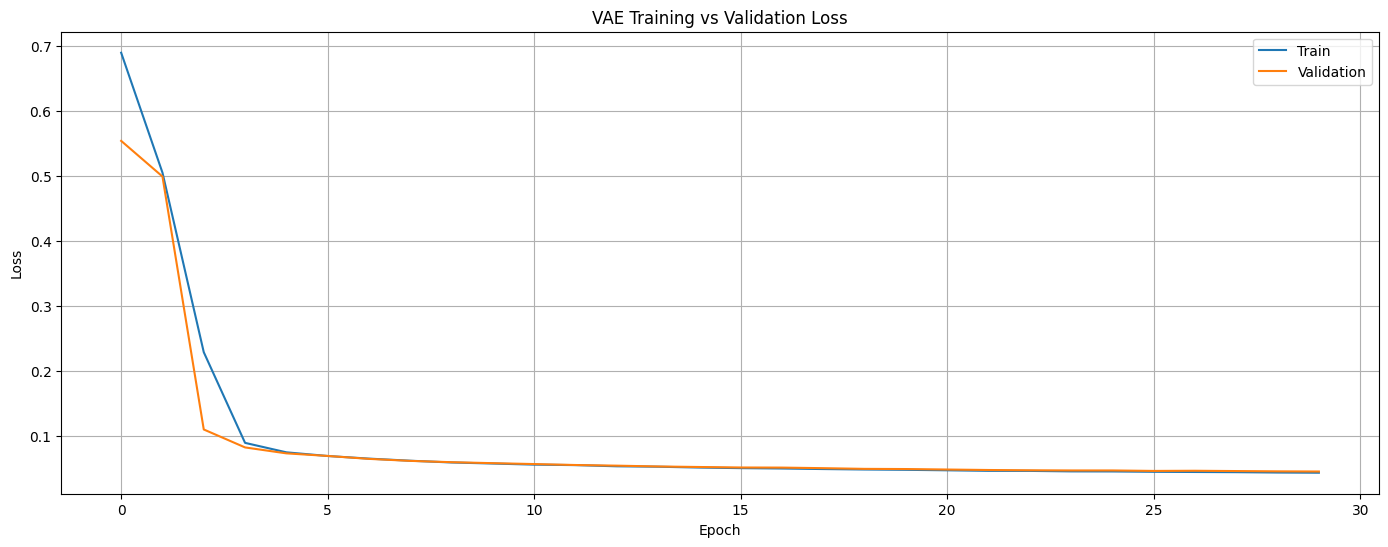

In [13]:
plt.figure(figsize=(17,6))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("VAE Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

### Visualize Reconstructions

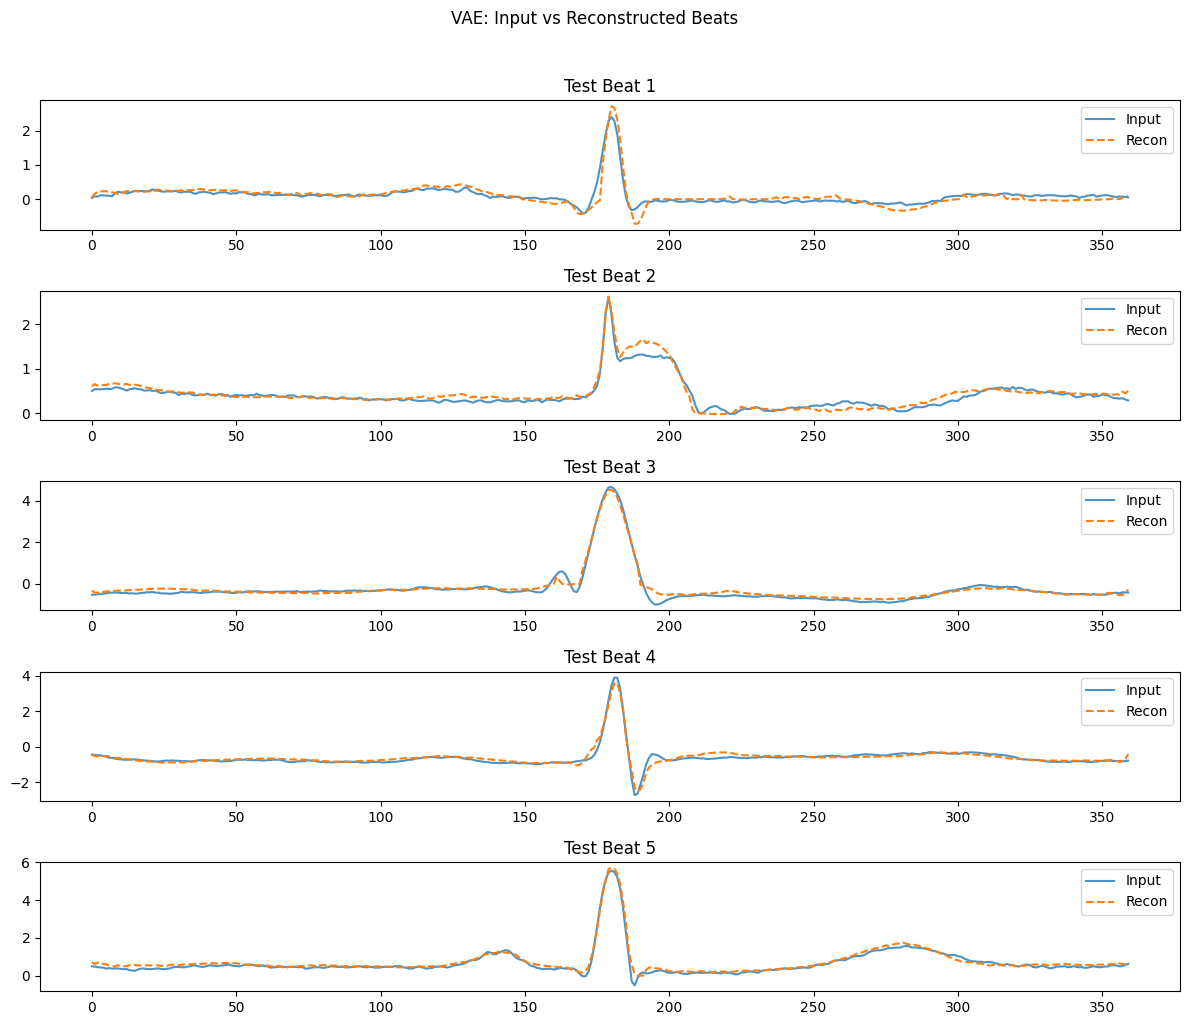

In [14]:
model.eval()
with torch.no_grad():
    batch = next(iter(test_loader)).to(device)
    recon, _, _ = model(batch)
    recon = recon.cpu().numpy()
    batch = batch.cpu().numpy()

plt.figure(figsize=(12, 10))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(batch[i, 0], label="Input", alpha=0.8)
    plt.plot(recon[i, 0], label="Recon", linestyle="--")
    plt.title(f"Test Beat {i+1}")
    plt.legend()
plt.suptitle("VAE: Input vs Reconstructed Beats", y=1.02)
plt.tight_layout()
plt.show()

### Generate New Synthetic Beats

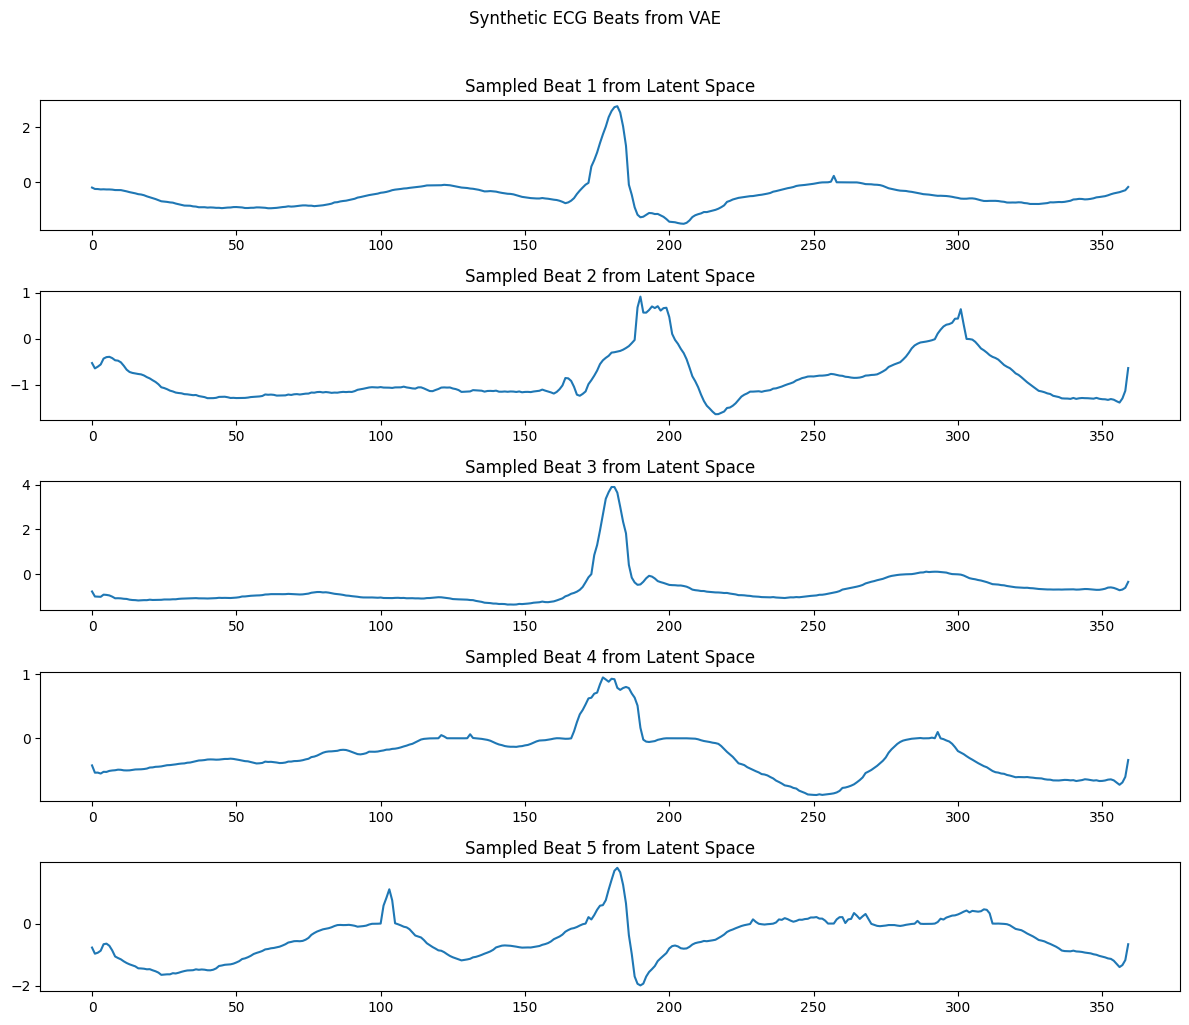

In [18]:
model.eval()
with torch.no_grad():
    z = torch.randn(5, 16).to(device)
    samples = model.decode(z).cpu().numpy()

plt.figure(figsize=(12, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(samples[i, 0])
    plt.title(f"Sampled Beat {i+1} from Latent Space")
plt.suptitle("Synthetic ECG Beats from VAE", y=1.02)
plt.tight_layout()
plt.show()
